<a href="https://colab.research.google.com/github/chacacaliza/Malaria-Classification/blob/main/VGG_Scenario.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/chacacaliza/Malaria-Classification.git

Cloning into 'Malaria-Classification'...
remote: Enumerating objects: 27568, done.
remote: Counting objects: 100% (27568/27568), done.
remote: Compressing objects: 100% (27567/27567), done.
remote: Total 27568 (delta 0), reused 27565 (delta 0), pack-reused 0
Receiving objects: 100% (27568/27568), 331.76 MiB | 14.68 MiB/s, done.
Checking out files: 100% (27561/27561), done.


In [2]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile

TRAIN_DIR = "/content/train/"
VALID_DIR ="/content/valid/"

os.mkdir(TRAIN_DIR)
os.mkdir(VALID_DIR)

for label in ['Uninfected', 'Parasitized']:
    os.mkdir(TRAIN_DIR+label)
    os.mkdir(VALID_DIR+label)

In [3]:
import random
def train_valid_test_split(source, train_dir, valid_dir,train_size, valid_size):
    # get files
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
    
    # train valid split
    train_size = int(len(files) * (1-train_size))
    valid_size = int(len(files) * (train_size))
  
    # shuffle the dataset
    shuffled_files = random.sample(files, len(files))
    
    train_set = shuffled_files[train_size:]
    valid_set = shuffled_files[:train_size]
    
    for filename in train_set:
        filepath = source + filename
        destination = train_dir + filename
        copyfile(filepath, destination)    
    
    for filename in valid_set:
        filepath = source + filename
        destination = valid_dir + filename
        copyfile(filepath, destination)

SOURCE = "/content/Malaria-Classification/Dataset/"

for label in ['Uninfected', 'Parasitized']:
    print(label)
    train_valid_test_split(SOURCE+label+'/', TRAIN_DIR +label+'/', VALID_DIR +label+'/', train_size=0.8, valid_size=0.2)
    print(len(os.listdir(TRAIN_DIR +label+'/')))
    print(len(os.listdir(VALID_DIR +label+'/')))

Uninfected
11025
2755
Parasitized
11025
2755


In [4]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (64, 64),
    color_mode='rgb',
    class_mode = 'binary',
    shuffle=True,
)

Found 22049 images belonging to 2 classes.


In [5]:
valid_datagen = ImageDataGenerator(
      rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size = (64, 64),
    color_mode='rgb',
    class_mode = 'binary',
    shuffle=True,
)

Found 5509 images belonging to 2 classes.


**SCENARIO WITH LEARNING RATE 99 akurasi**

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB5
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout, BatchNormalization
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [7]:
classifier_vgg19 = VGG19(input_shape= (64,64,3),include_top=False,weights='imagenet')

80150528/80134624 [==============================] - 2s 0us/step


In [8]:
for layer in classifier_vgg19.layers:
    layer.trainable = False

In [9]:
classifier1 = classifier_vgg19.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.2)(classifier1)
classifier1 = BatchNormalization()(classifier1)
classifier1 = Dense(units=1, activation='sigmoid')(classifier1)

model = Model(inputs = classifier_vgg19.input , outputs = classifier1)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [11]:
history = model.fit(train_generator,
                   epochs = 100,
                   validation_data = valid_generator,
                   callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_loss',
                       factor=0.5,
                       patience=40,
                       verbose = 1,
                       mode= 'auto',
                       cooldown = 1
                   )])

Epoch 1/100
690/690 [==============================] - 60s 71ms/step - loss: 0.3056 - accuracy: 0.8711 - val_loss: 0.2206 - val_accuracy: 0.9163 - lr: 1.0000e-04
Epoch 2/100
690/690 [==============================] - 44s 64ms/step - loss: 0.2352 - accuracy: 0.9079 - val_loss: 0.2314 - val_accuracy: 0.9078 - lr: 1.0000e-04
Epoch 3/100
690/690 [==============================] - 44s 64ms/step - loss: 0.2122 - accuracy: 0.9182 - val_loss: 0.2068 - val_accuracy: 0.9212 - lr: 1.0000e-04
Epoch 4/100
690/690 [==============================] - 43s 62ms/step - loss: 0.2031 - accuracy: 0.9207 - val_loss: 0.1894 - val_accuracy: 0.9305 - lr: 1.0000e-04
Epoch 5/100
690/690 [==============================] - 43s 62ms/step - loss: 0.1954 - accuracy: 0.9264 - val_loss: 0.1843 - val_accuracy: 0.9272 - lr: 1.0000e-04
Epoch 6/100
690/690 [==============================] - 43s 63ms/step - loss: 0.1905 - accuracy: 0.9288 - val_loss: 0.2000 - val_accuracy: 0.9214 - lr: 1.0000e-04
Epoch 7/100
690/690 [=======

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model):
  valid_generator = train_datagen.flow_from_directory(
      TRAIN_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='binary',
      shuffle = False)

  Y_pred = model.predict_generator(valid_generator)
  y_pred = np.round(Y_pred).astype(int)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(valid_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['Parasitized','Uninfected']
  print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

  tn, fp, fn, tp = cm.ravel()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f = 2*((precision*recall)/(precision+recall))

  print("Recall of the model is {:.2f}".format(recall))
  print("Precision of the model is {:.2f}".format(precision))
  print("F-1 Score of the model is {:.2f}".format(f)) 

Found 22049 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]



Confusion Matrix



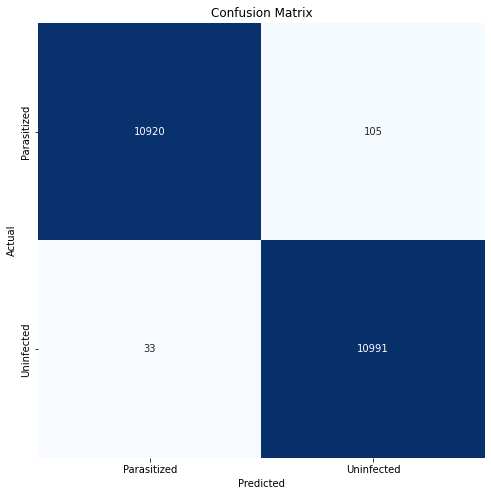



Classification Report

              precision    recall  f1-score   support

 Parasitized       1.00      0.99      0.99     11025
  Uninfected       0.99      1.00      0.99     11024

    accuracy                           0.99     22049
   macro avg       0.99      0.99      0.99     22049
weighted avg       0.99      0.99      0.99     22049

Recall of the model is 1.00
Precision of the model is 0.99
F-1 Score of the model is 0.99


In [13]:
evaluate(model)

In [16]:
import matplotlib.pyplot as plt
def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])
  plt.savefig("Accuracy Plot.svg", format="svg", dpi=1200)

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])
  #save plot svg
  plt.savefig("Loss Plot.svg", format="svg", dpi=1200)

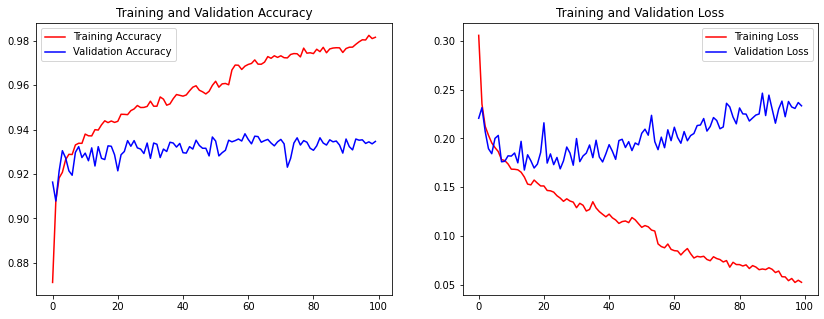

In [17]:
eval_plot(history)

In [18]:
model.save_weights("vgg19.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
# serialize model to JSON
model_json = model.to_json()
with open("vgg19.json", "w") as json_file: json_file.write(model_json)

In [20]:
# serialize weights to HDF5
model.save("vgg19.h5")
print("Saved model to disk")

Saved model to disk


In [21]:
from tensorflow.keras.models import Sequential, load_model

Model : vgg19.h5
Predicted Label : Parasitized
Probability : 0.0017



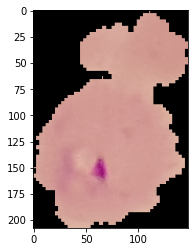

In [22]:
from PIL import Image
import cv2

img_upload = Image.open("/content/Malaria-Classification/Dataset/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png")
img_plt = plt.imshow(img_upload)
img = np.array(img_upload)
img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)

model_list = ['/content/vgg19.h5']
labels = ['Parasitized','Uninfected']

for m in model_list:
    model = load_model(m)
    imgs = cv2.resize(img, (64,64))
    imgs = imgs.astype('float32') / 255
    pred = model.predict(np.expand_dims(imgs, axis=0))[0]
    print('Model :', m.split('/')[-1])
    print('Predicted Label :',labels[((pred > 0.5)+0).ravel()[0]])
    print('Probability :',[ round(elem, 4) for elem in pred ][0])
    print('===============\n')

Model : vgg19.h5
Predicted Label : Uninfected
Probability : 0.9354



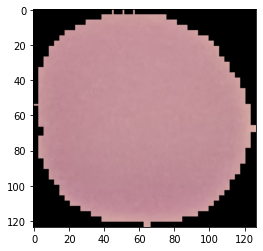

In [23]:
from PIL import Image
import cv2

img_upload = Image.open("/content/Malaria-Classification/Dataset/Uninfected/C114P75ThinF_IMG_20150930_150733_cell_62.png")
img_plt = plt.imshow(img_upload)
img = np.array(img_upload)
img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)

model_list = ['/content/vgg19.h5']
labels = ['Parasitized','Uninfected']

for m in model_list:
    model = load_model(m)
    imgs = cv2.resize(img, (64,64))
    imgs = imgs.astype('float32') / 255
    pred = model.predict(np.expand_dims(imgs, axis=0))[0]
    print('Model :', m.split('/')[-1])
    print('Predicted Label :',labels[((pred > 0.5)+0).ravel()[0]])
    print('Probability :',[ round(elem, 4) for elem in pred ][0])
    print('===============\n')

**VGG ADAM OPTIMIZER**

In [6]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import EfficientNetB5
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout, BatchNormalization
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2

In [ ]:
classifier_vgg19 = VGG19(input_shape= (64,64,3),include_top=False,weights='imagenet')

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in classifier_vgg19.layers:
    layer.trainable = False

In [ ]:
classifier1 = classifier_vgg19.output#head mode
classifier1 = Flatten()(classifier1)#adding layer of flatten
classifier1 = Dense(units=256, activation='relu')(classifier1)
classifier1 = Dropout(0.1)(classifier1)
classifier1 = BatchNormalization()(classifier1)
classifier1 = Dense(units=1, activation='sigmoid')(classifier1)

model = Model(inputs = classifier_vgg19.input , outputs = classifier1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

In [ ]:
history = model.fit(train_generator,
                   epochs = 100,
                   validation_data = valid_generator,
                   callbacks=[tf.keras.callbacks.ReduceLROnPlateau(
                       monitor='val_loss',
                       factor=0.5,
                       patience=40,
                       verbose = 1,
                       mode= 'auto',
                       cooldown = 1
                   )])

Epoch 1/100
689/689 [==============================] - 47s 67ms/step - loss: 0.2709 - accuracy: 0.8910 - val_loss: 0.2168 - val_accuracy: 0.9201 - lr: 0.0010
Epoch 2/100
689/689 [==============================] - 44s 63ms/step - loss: 0.2314 - accuracy: 0.9106 - val_loss: 0.2477 - val_accuracy: 0.9007 - lr: 0.0010
Epoch 3/100
689/689 [==============================] - 44s 64ms/step - loss: 0.2220 - accuracy: 0.9173 - val_loss: 0.4803 - val_accuracy: 0.8044 - lr: 0.0010
Epoch 4/100
689/689 [==============================] - 43s 63ms/step - loss: 0.2169 - accuracy: 0.9189 - val_loss: 0.3683 - val_accuracy: 0.8521 - lr: 0.0010
Epoch 5/100
689/689 [==============================] - 43s 63ms/step - loss: 0.2070 - accuracy: 0.9200 - val_loss: 0.2003 - val_accuracy: 0.9272 - lr: 0.0010
Epoch 6/100
689/689 [==============================] - 43s 63ms/step - loss: 0.2042 - accuracy: 0.9225 - val_loss: 0.1994 - val_accuracy: 0.9260 - lr: 0.0010
Epoch 7/100
689/689 [==============================]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate(model):
  valid_generator = train_datagen.flow_from_directory(
      TRAIN_DIR, 
      target_size=(64,64), 
      batch_size=32, 
      class_mode='binary',
      shuffle = False)

  Y_pred = model.predict_generator(valid_generator)
  y_pred = np.round(Y_pred).astype(int)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(valid_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Parasitized','Uninfected'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['Parasitized','Uninfected']
  print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

  tn, fp, fn, tp = cm.ravel()

  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f = 2*((precision*recall)/(precision+recall))

  print("Recall of the model is {:.2f}".format(recall))
  print("Precision of the model is {:.2f}".format(precision))
  print("F-1 Score of the model is {:.2f}".format(f)) 

Found 22048 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  del sys.path[0]



Confusion Matrix



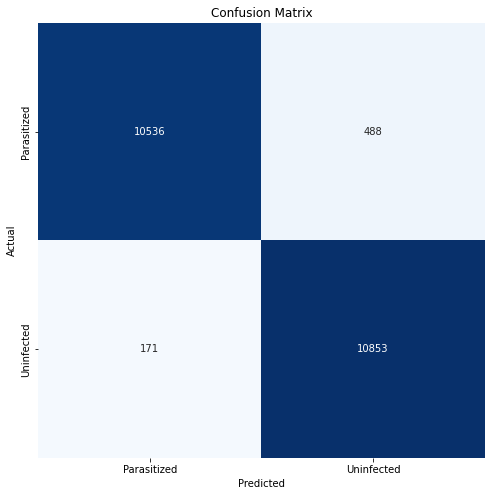



Classification Report

              precision    recall  f1-score   support

 Parasitized       0.98      0.96      0.97     11024
  Uninfected       0.96      0.98      0.97     11024

    accuracy                           0.97     22048
   macro avg       0.97      0.97      0.97     22048
weighted avg       0.97      0.97      0.97     22048

Recall of the model is 0.98
Precision of the model is 0.96
F-1 Score of the model is 0.97


In [ ]:
evaluate(model)

In [ ]:
import matplotlib.pyplot as plt
def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])
  plt.savefig("Accuracy Plot.svg", format="svg", dpi=1200)

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])
  #save plot svg
  plt.savefig("Loss Plot.svg", format="svg", dpi=1200)

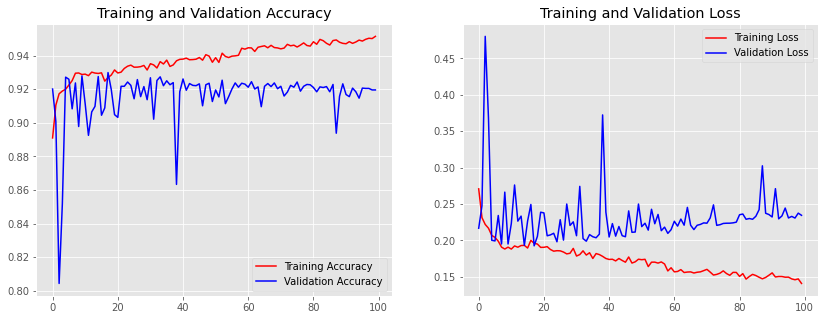

In [ ]:
eval_plot(history)

In [ ]:
model.save_weights("VGG19.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("VGG19.json", "w") as json_file: json_file.write(model_json)

In [ ]:
# serialize weights to HDF5
model.save("VGG19.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from tensorflow.keras.models import Sequential, load_model

Model : VGG19.h5
Predicted Label : Parasitized
Probability : 0.0



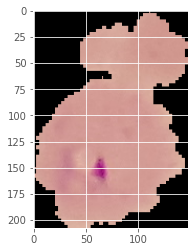

In [ ]:
from PIL import Image
import cv2

img_upload = Image.open("/content/Malaria-Classification/Dataset/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png")
img_plt = plt.imshow(img_upload)
img = np.array(img_upload)
img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)

model_list = ['/content/VGG19.h5']
labels = ['Parasitized','Uninfected']

for m in model_list:
    model = load_model(m)
    imgs = cv2.resize(img, (64,64))
    imgs = imgs.astype('float32') / 255
    pred = model.predict(np.expand_dims(imgs, axis=0))[0]
    print('Model :', m.split('/')[-1])
    print('Predicted Label :',labels[((pred > 0.5)+0).ravel()[0]])
    print('Probability :',[ round(elem, 4) for elem in pred ][0])
    print('===============\n')

Model : VGG19.h5
Predicted Label : Uninfected
Probability : 0.9287



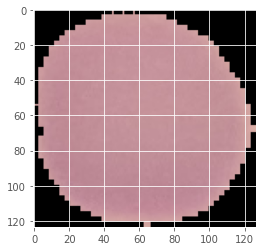

In [ ]:
from PIL import Image
import cv2

img_upload = Image.open("/content/Malaria-Classification/Dataset/Uninfected/C114P75ThinF_IMG_20150930_150733_cell_62.png")
img_plt = plt.imshow(img_upload)
img = np.array(img_upload)
img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)

model_list = ['/content/VGG19.h5']
labels = ['Parasitized','Uninfected']

for m in model_list:
    model = load_model(m)
    imgs = cv2.resize(img, (64,64))
    imgs = imgs.astype('float32') / 255
    pred = model.predict(np.expand_dims(imgs, axis=0))[0]
    print('Model :', m.split('/')[-1])
    print('Predicted Label :',labels[((pred > 0.5)+0).ravel()[0]])
    print('Probability :',[ round(elem, 4) for elem in pred ][0])
    print('===============\n')